EDA 2: The data strikes back
Int this exploration of the danish censu's, i will try to:
 - make a summation plot of when a certain percentage of the population is married / has been married.
 - Try to calculate the naive avarage age of marriage for different population groups
 - Try to calculate the naive avarage age of marriage for differnet parishes 

In [18]:
# imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import plotly.graph_objs as go
import json
from typing import List

from helper_functions import clean_data_age_gender, split_csv

#Future proofing of the way we use pandas
pd.options.mode.copy_on_write = True

In [19]:
# import test data
census_data_dir = Path.cwd().parent / 'data' / 'census'

# we load in the first of the census to explore that data
first_census_df = pd.read_csv(census_data_dir / "cph" / 'Rigsarkivet_folketælling_Kobenhavn_amt_1787.csv', delimiter='$')

cleaned_census_df, _, _ = clean_data_age_gender(first_census_df)

In [20]:
cleaned_census_df['parish'].unique()

array(['Øster Kvarter', 'Købmager Kvarter', 'Store Magleby',
       'Klædebo Kvarter', 'Frimand Kvarter', 'Sengeløse', 'Hvidovre',
       'Ledøje', 'Ballerup', 'Herstedøster', 'Maaløv',
       'Sankt Annæ Vester Kvarter', 'Gladsakse', 'Lyngby',
       'Hof & Militæretaten', 'Smørum', 'Høje Taastrup', 'Taarnby',
       'Sankt Annæ Øster Kvarter', 'Strand Kvarter', 'Vallensbæk',
       'Christianshavn Kvarter', 'Torslunde', 'Frederiksberg', 'Værløse',
       'Snarens Kvarter', 'Udenbys Vester Kvarter', 'Sankt Hans Hospital',
       'Brøndbyvester', 'Brøndbyøster', 'Nørre Kvarter', 'Herlev',
       'Udenbys Klædebo Kvarter', 'Rosenborg Kvarter', 'Rødovre',
       'Vester Kvarter', 'Gentofte', 'Ishøj', 'Glostrup', 'Herstedvester',
       'Søllerød', 'Brønshøj'], dtype=object)

In [24]:
# Functions
def calc_cumulative_percentage(group: pd.DataFrame) -> pd.DataFrame:
    """Calculate cumulative percentage for a group (df), add them to the df and return the changed df."""
    group = group.sort_values('age_full_years')
    group['total'] = 1
    group['married_or_separated'] = (group['marital_status'].isin(['Gift', 'Separeret', 'Skilt', 'Enke'])).astype(int)
    group['cumulative_total'] = group['total'].cumsum()
    group['cumulative_married_or_separated'] = group['married_or_separated'].cumsum()
    group['cumulative_percentage'] = (group['cumulative_married_or_separated'] / group['cumulative_total']) * 100
    return group

def create_facet_plot(df: pd.DataFrame) -> sns.FacetGrid:
    """Create a facet plot for the given DataFrame."""
    sns.set_theme(style="whitegrid")
    g = sns.FacetGrid(df, col="parish", col_wrap=2, height=4, aspect=1.5)
    g.map(plt.plot, "age", "cumulative_percentage", marker="o")
    g.map(add_labels, "age", "cumulative_percentage")  # Corrected line
    g.set_axis_labels("Age", "Cumulative Percentage Married or Separated")
    g.set_titles("Parish {col_name}")
    g.figure.suptitle('Cumulative Percentage of Married or Separated Population by Age and Parish', y=1.02)
    g.set(ylim=(0, 100))
    return g

def add_labels(x: pd.Series, y: pd.Series, **kwargs) -> None:
    """Add labels to the start and end points of the plot."""
    ax = plt.gca()
    ax.text(x.iloc[0], y.iloc[0], f"{y.iloc[0]:.1f}%", verticalalignment='bottom')
    ax.text(x.iloc[-1], y.iloc[-1], f"{y.iloc[-1]:.1f}%", verticalalignment='bottom')

def create_cumsum_marriage_plot_by_parish(data: pd.DataFrame) -> sns.FacetGrid:
    """Create a facet plot for the given DataFrame."""
    data = data.groupby('parish').apply(calc_cumulative_percentage).reset_index(drop=True)
    g = create_facet_plot(data)
    return g

def create_cumsum_marriage_plot(data: pd.DataFrame):
    
    # Group by age and calculate the count and number of married/separated people for each age
    age_marriage = data.groupby('age_full_years').agg({
        'marital_status': ['count', lambda x: ((x == 'Gift') | (x == 'Separeret') | (x == 'Skilt') | (x == 'Enke')).sum()]
    }).reset_index()
    age_marriage.columns = ['age', 'total', 'married_or_separated']

    # Sort the DataFrame by age
    age_marriage = age_marriage.sort_values('age')

    # Calculate cumulative totals and cumulative married/separated
    age_marriage['cumulative_total'] = age_marriage['total'].cumsum()
    age_marriage['cumulative_married_or_separated'] = age_marriage['married_or_separated'].cumsum()

    # Calculate the correct cumulative percentage
    age_marriage['cumulative_percentage'] = (age_marriage['cumulative_married_or_separated'] / age_marriage['cumulative_total']) * 100

    # Create the line plot
    plt.figure(figsize=(12, 6))
    plt.plot(age_marriage['age'], age_marriage['cumulative_percentage'], marker='o')

    # Customize the plot
    plt.title('Cumulative Percentage of Married or Separated Population by Age')
    plt.xlabel('Age')
    plt.ylabel('Cumulative Percentage Married or Separated')
    plt.grid(True)

    # Add labels to the start and end points
    plt.text(age_marriage['age'].iloc[0], age_marriage['cumulative_percentage'].iloc[0], 
            f"{age_marriage['cumulative_percentage'].iloc[0]:.1f}%", 
            verticalalignment='bottom')
    plt.text(age_marriage['age'].iloc[-1], age_marriage['cumulative_percentage'].iloc[-1], 
            f"{age_marriage['cumulative_percentage'].iloc[-1]:.1f}%", 
            verticalalignment='bottom')

    # Set y-axis to percentage scale
    plt.ylim(0, 100)

    return plt.gcf()

C:\Users\mlind\AppData\Local\Temp\ipykernel_11164\3363464701.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
C:\Users\mlind\AppData\Local\Temp\ipykernel_11164\3363464701.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
C:\Users\mlind\AppData\Local\Temp\ipykernel_11164\3363464701.py:4: DtypeWarning: Columns (3,4,9,14,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
C:\Users\mlind\AppData\Local\Temp\ipykernel_11164\3363464701.py:4: DtypeWarning: Columns (4,6,18,19,22,23,24,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
C:\Users\mlind\AppData\Local\Temp\ipykernel_11164\3363464701.py:4: DtypeWar

IndexError: single positional indexer is out-of-bounds

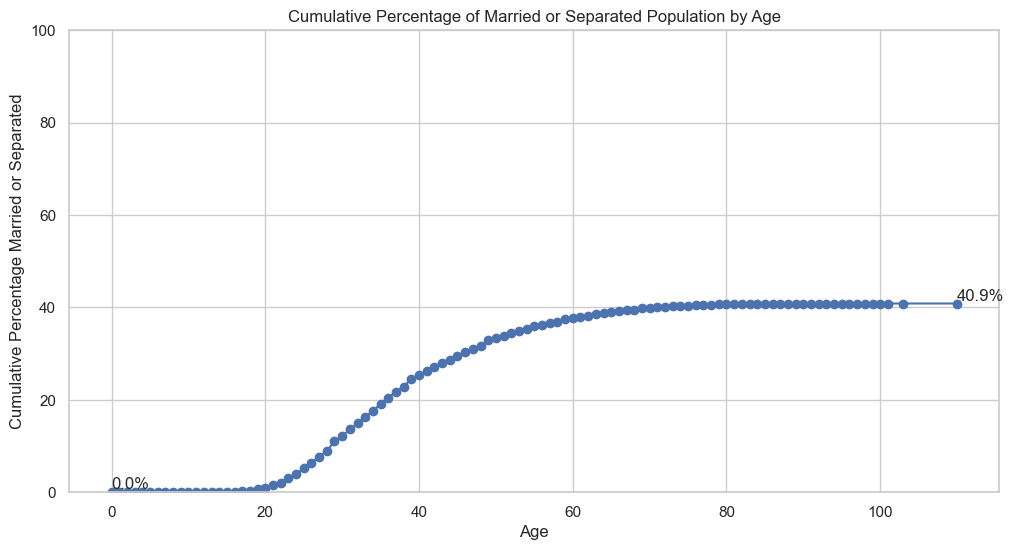

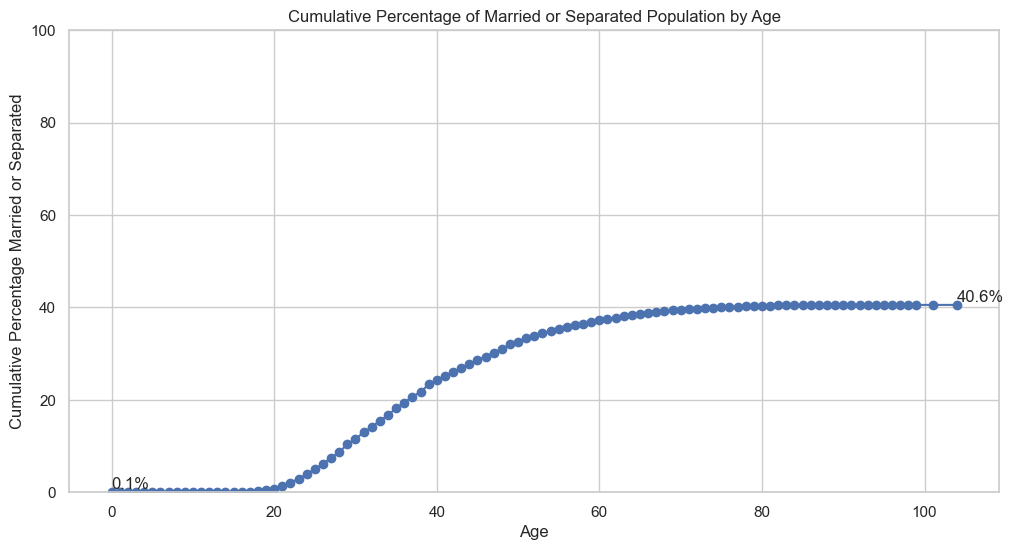

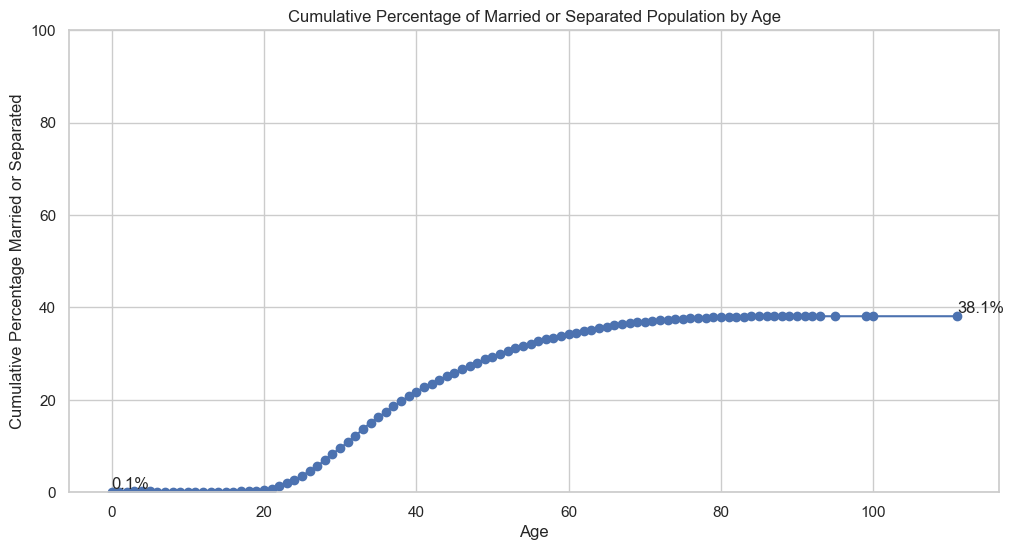

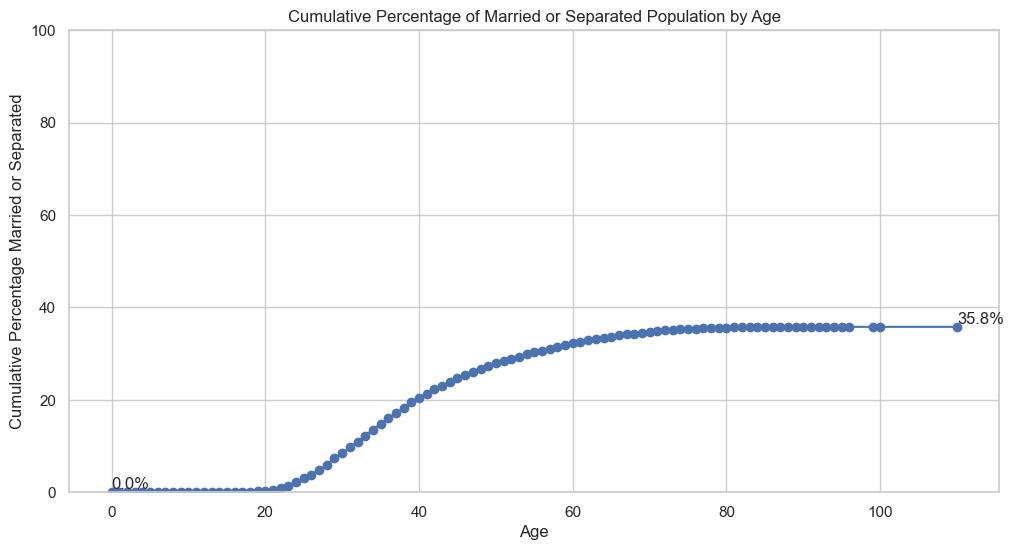

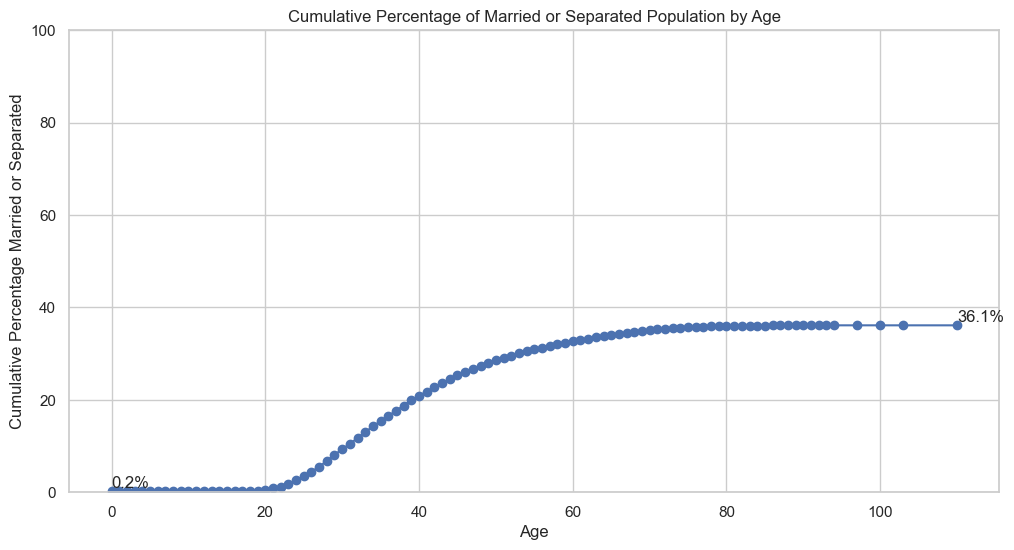

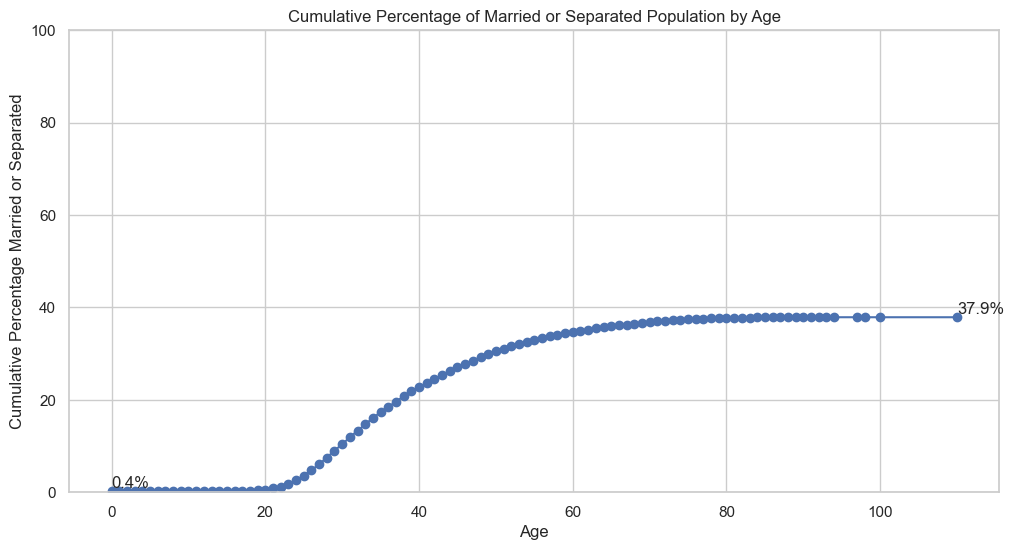

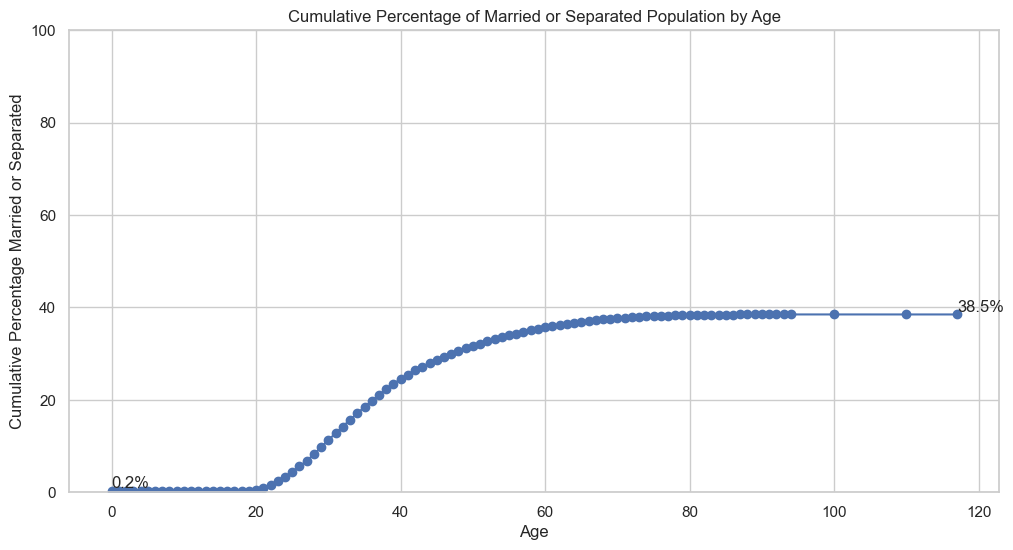

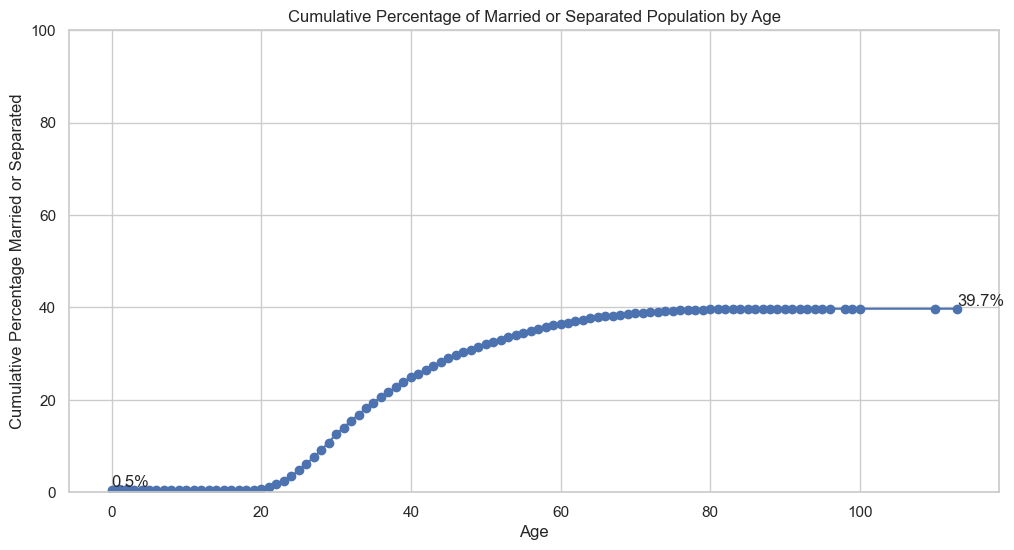

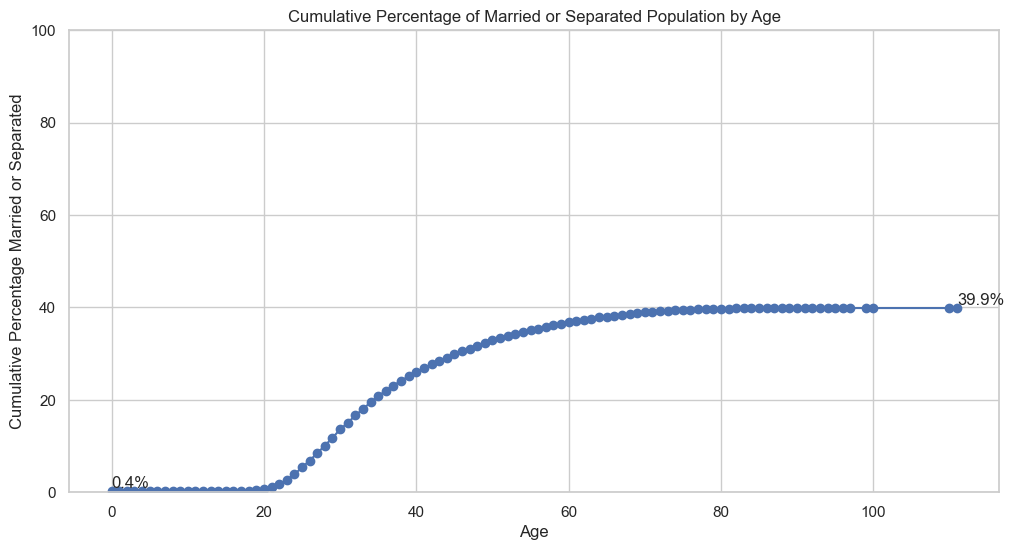

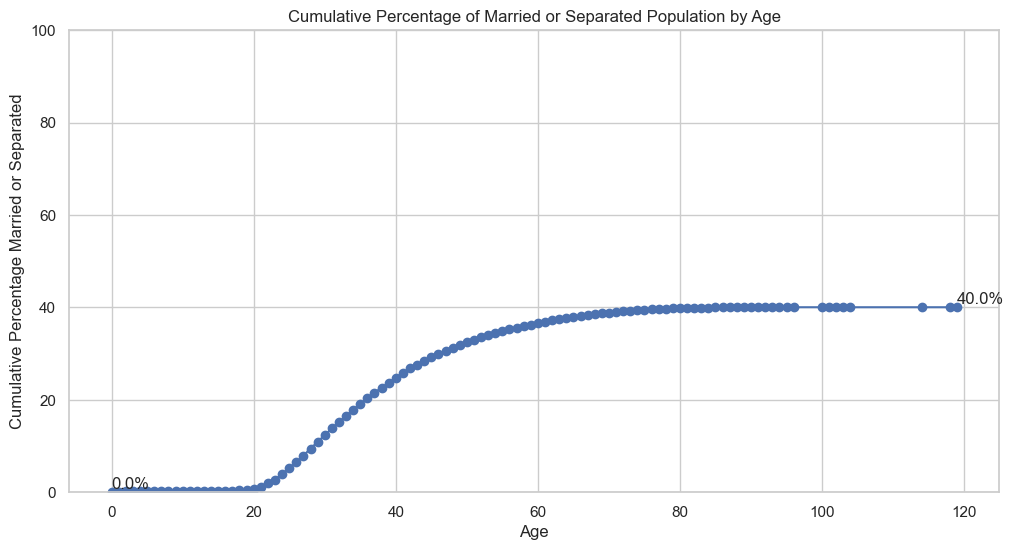

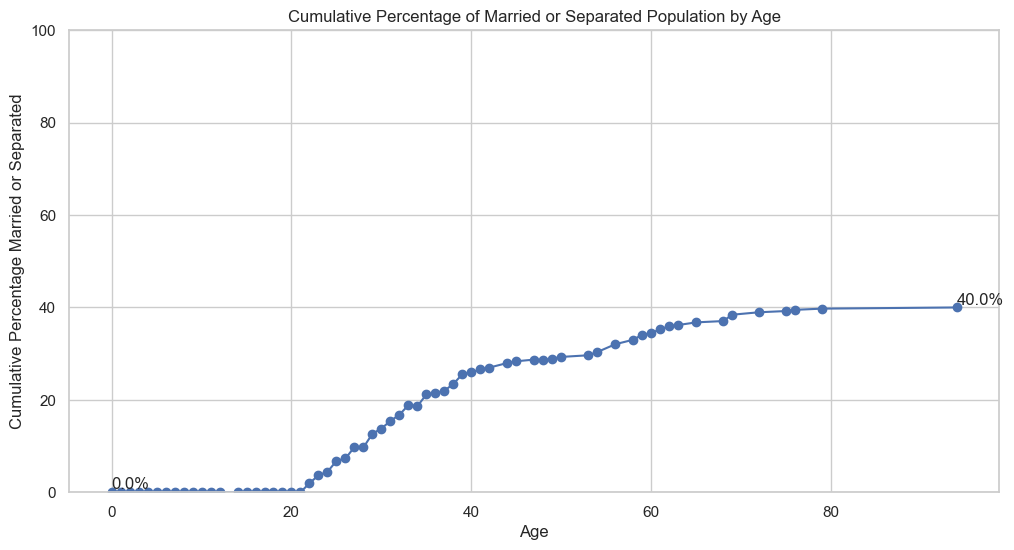

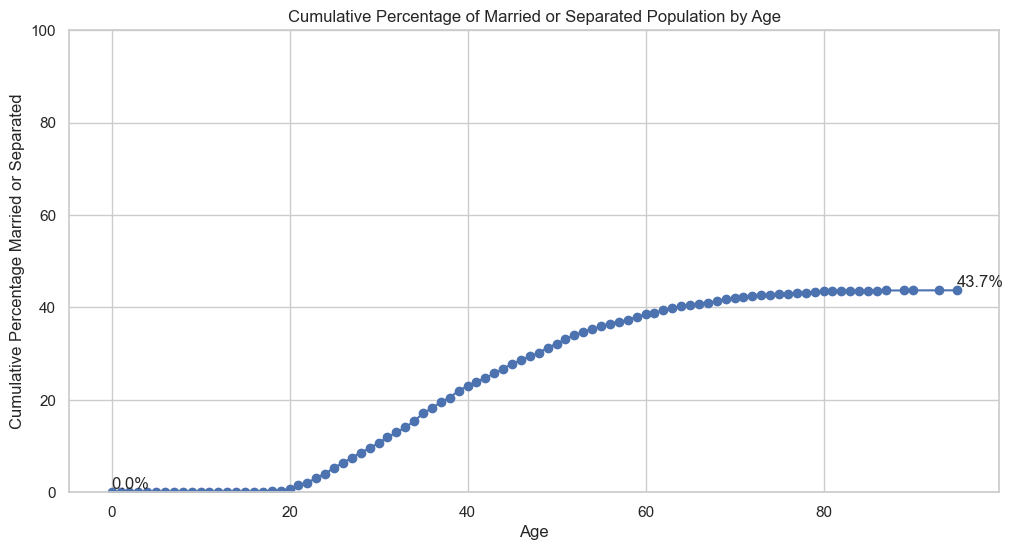

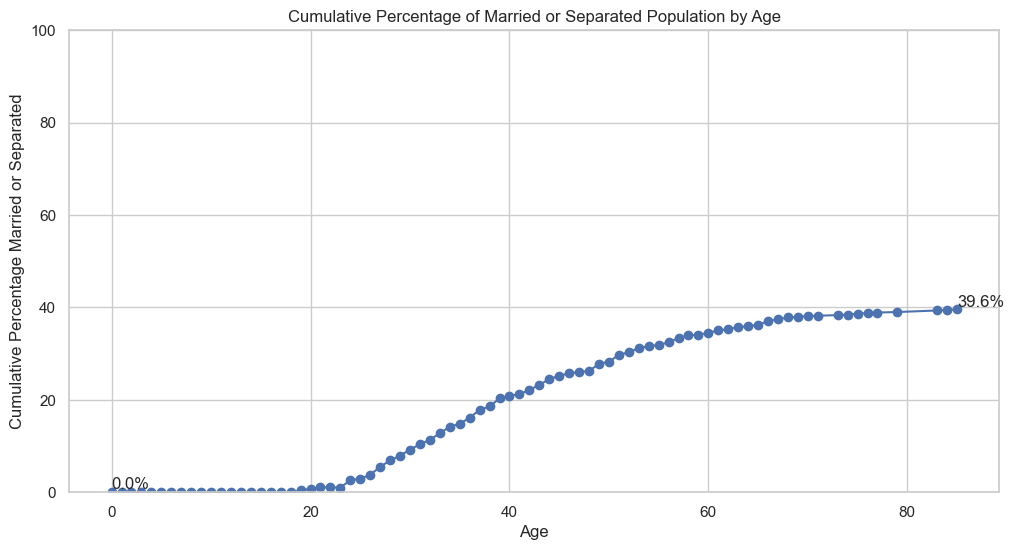

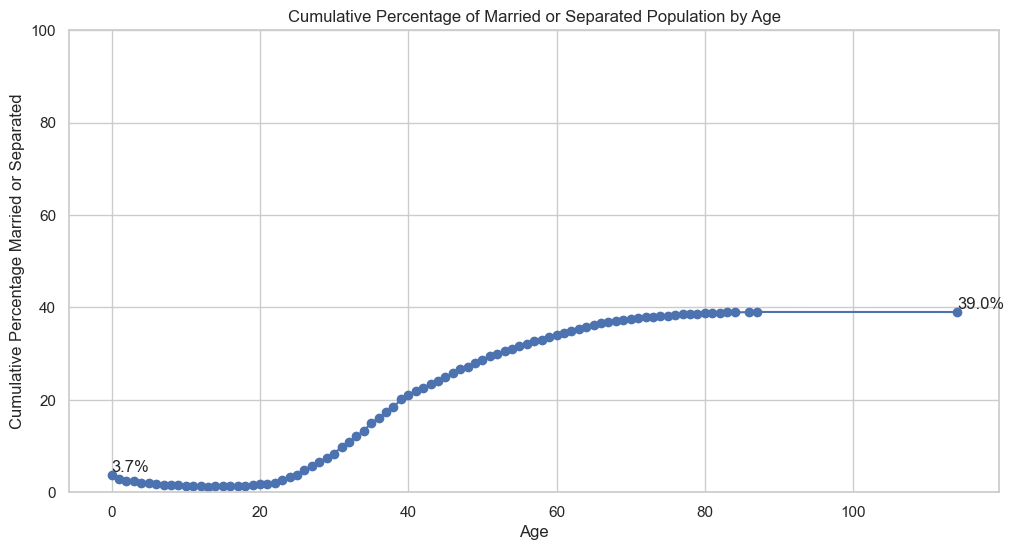

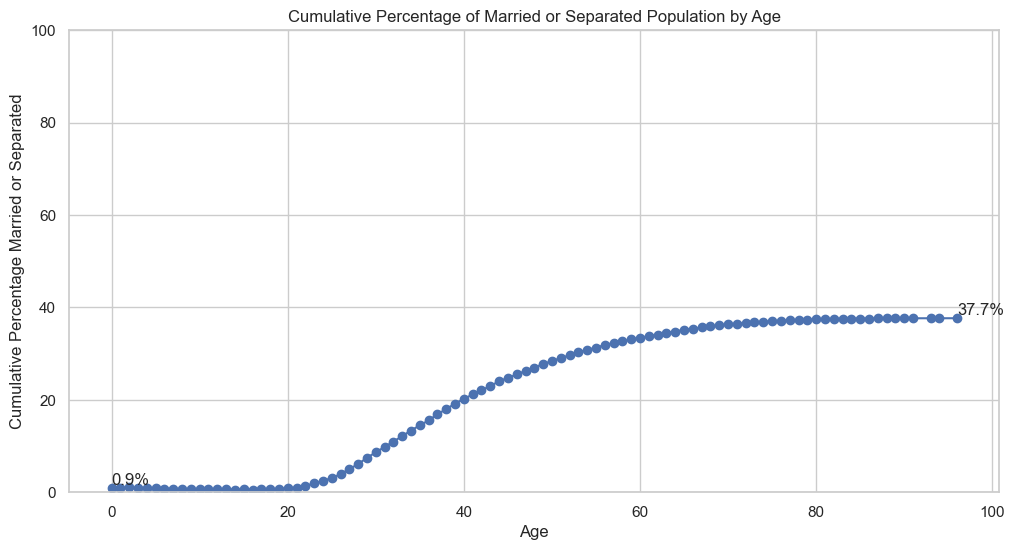

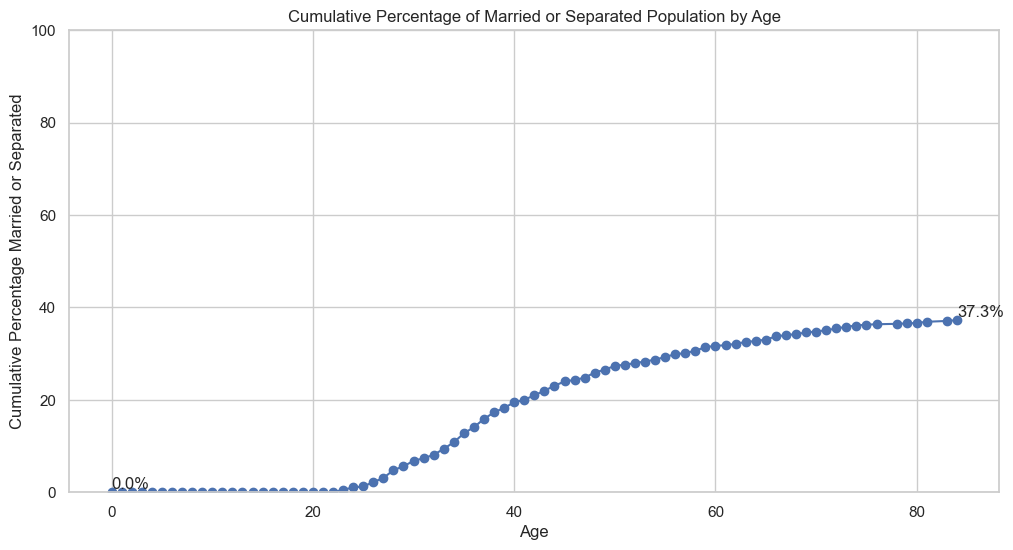

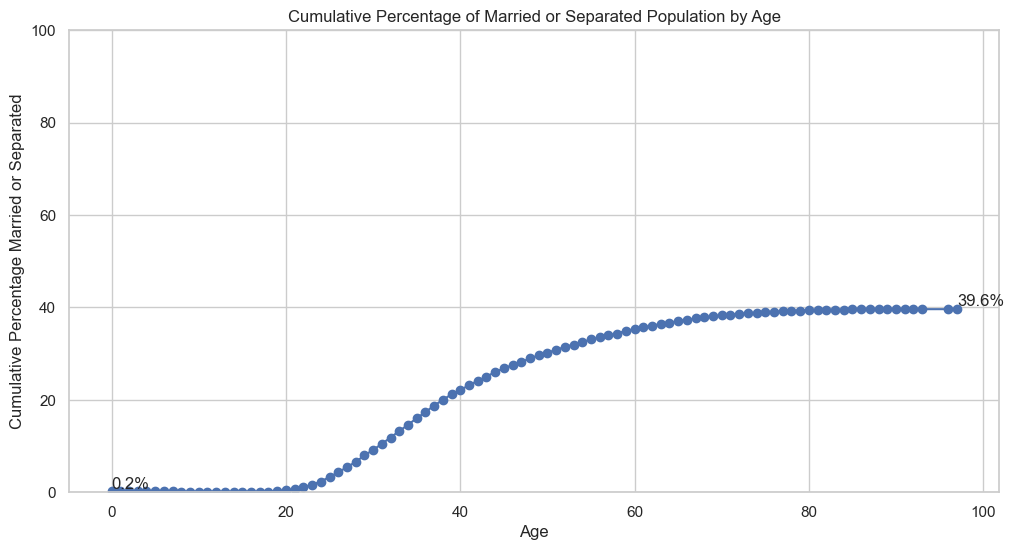

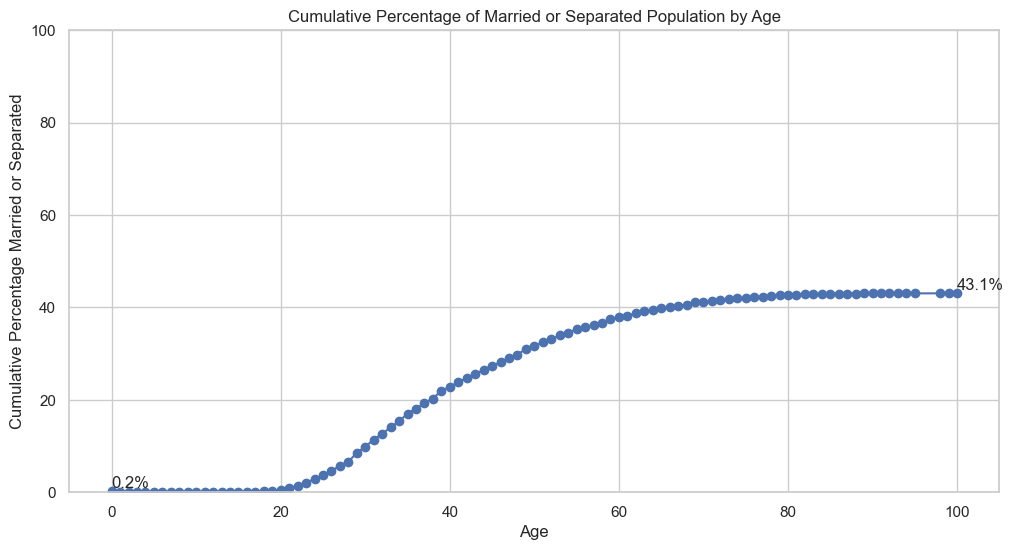

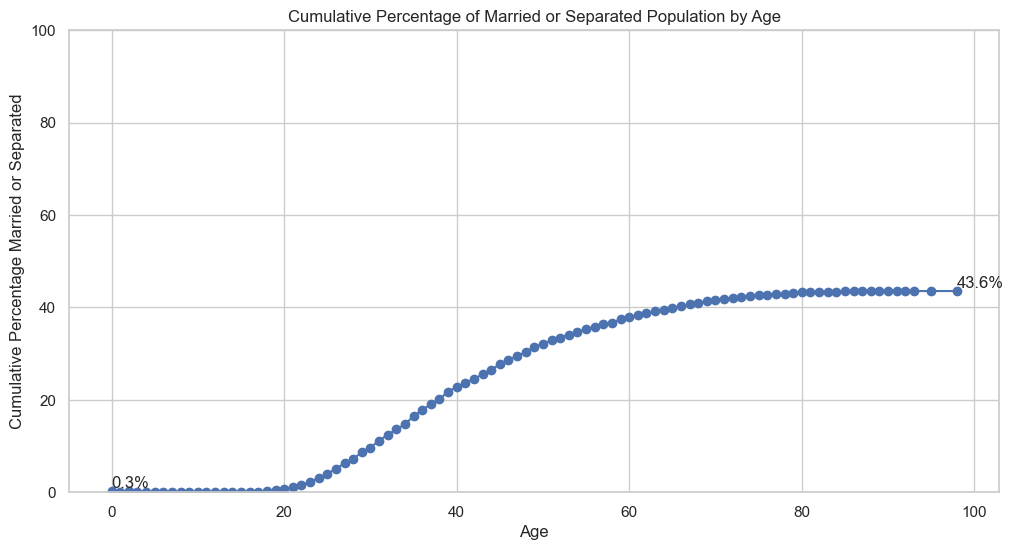

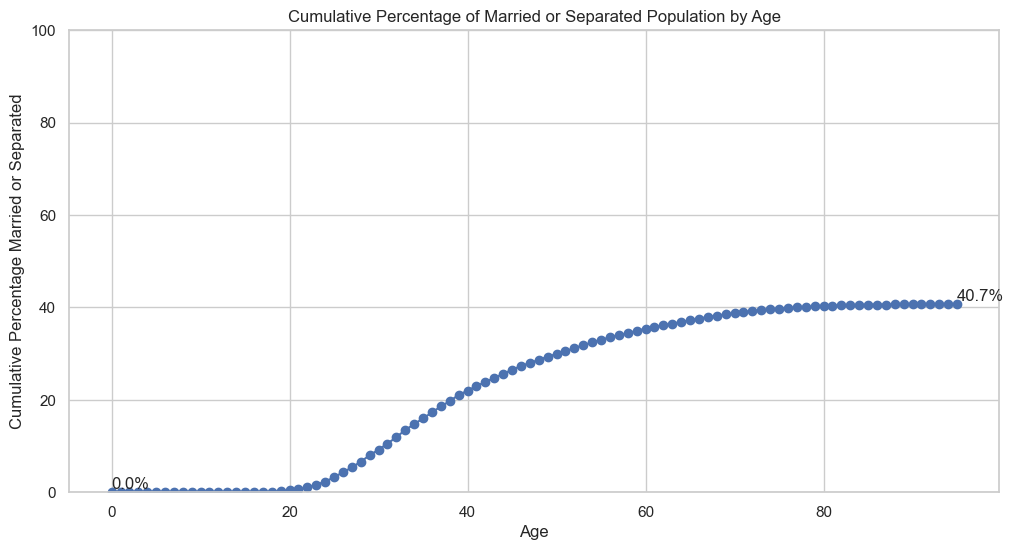

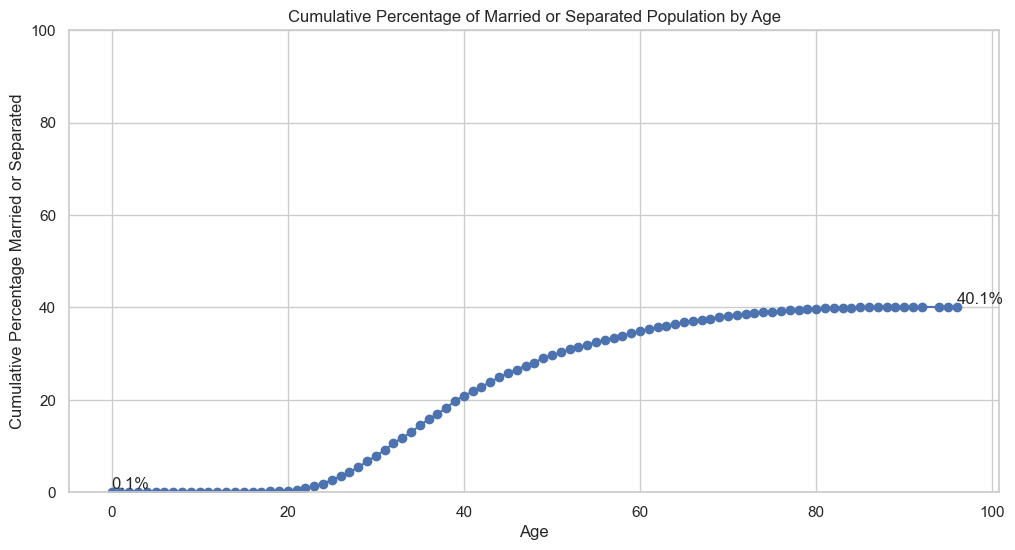

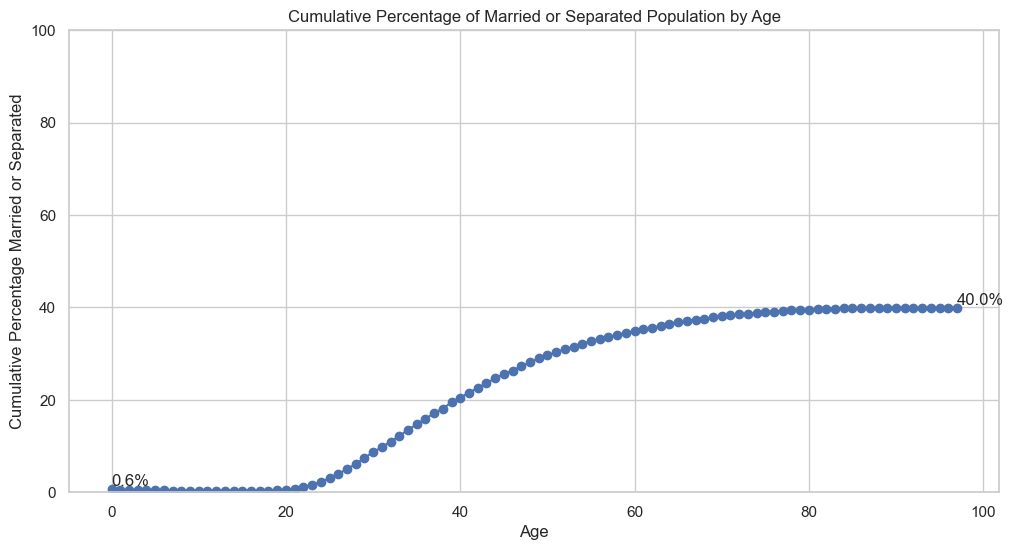

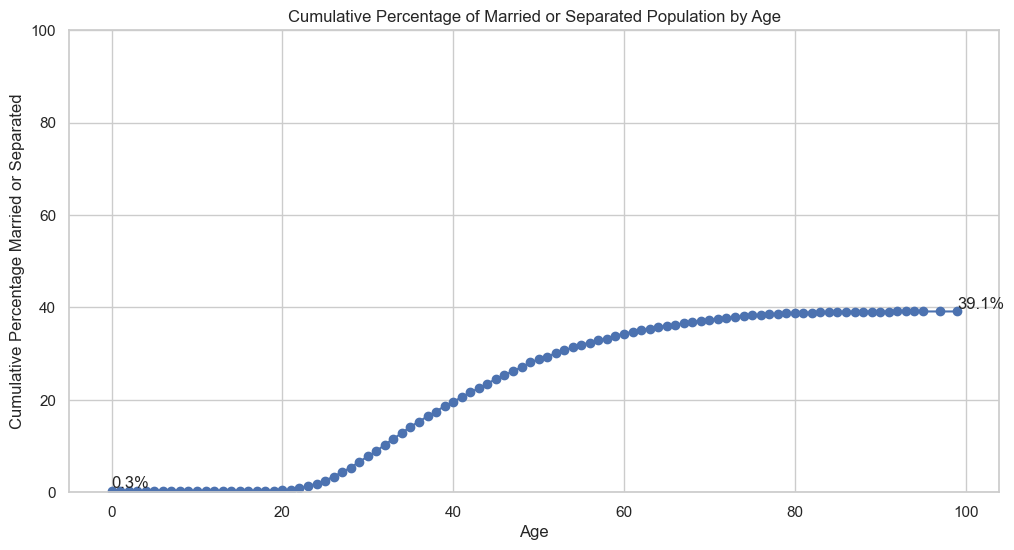

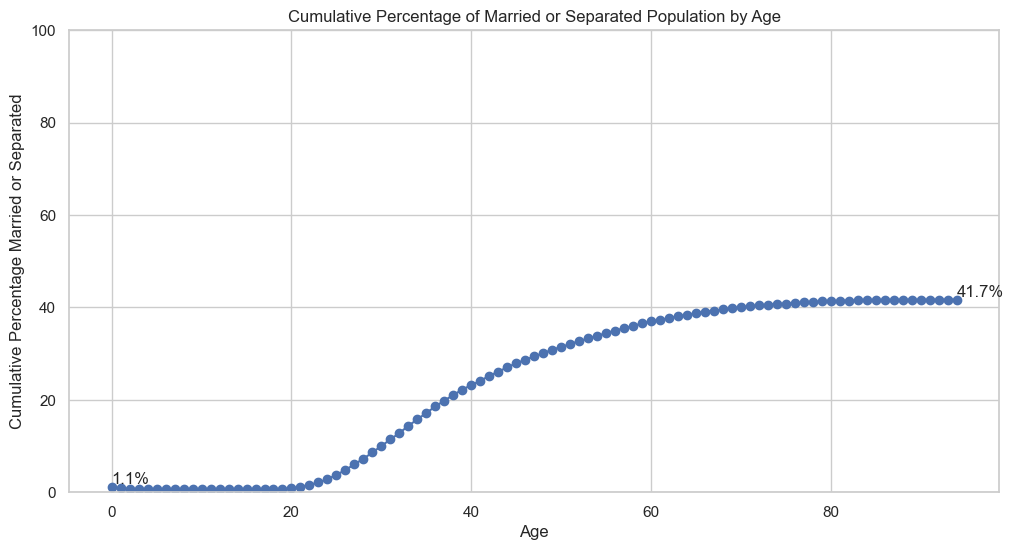

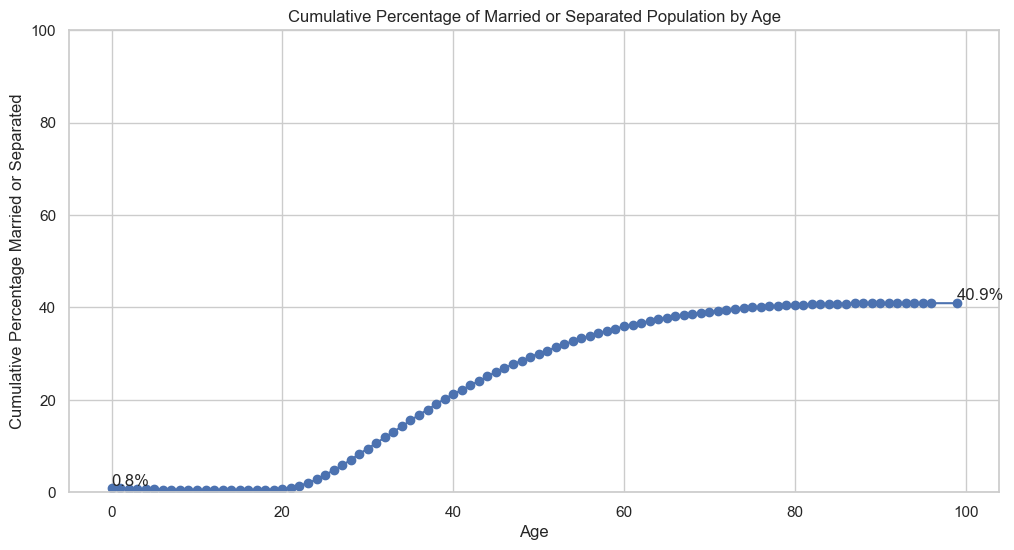

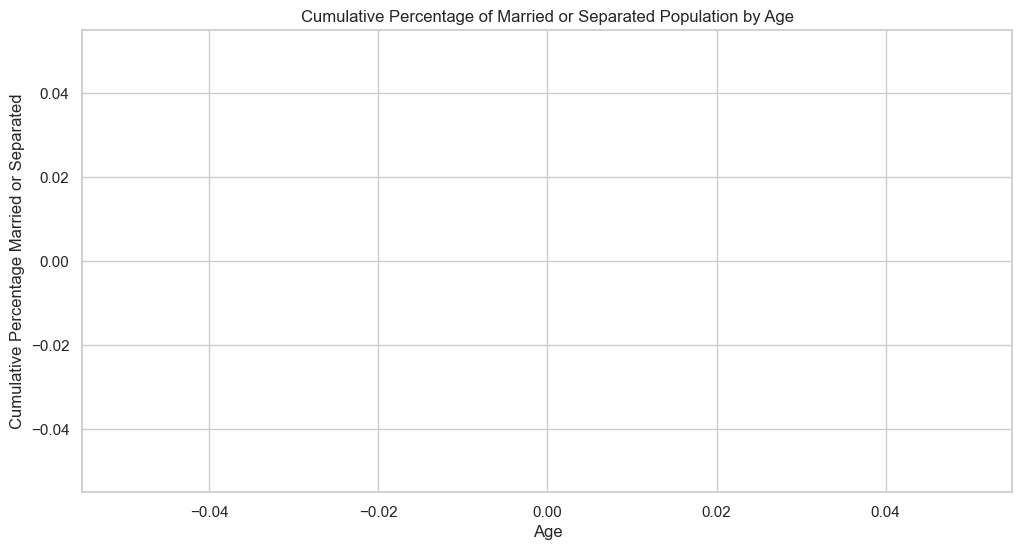

In [25]:
# Main loop for plotting the marriage status of the population
for dir in census_data_dir.iterdir():
    for census in dir.iterdir():
        census_df = pd.read_csv(census, delimiter='$')
        cleaned_census_df, _, _ = clean_data_age_gender(census_df)
        plot_cumsum_marriage_by_parish = create_cumsum_marriage_plot(cleaned_census_df)
        plot_cumsum_marriage_by_parish.savefig(Path(census_data_dir.parent / 'images' / dir.stem / 'CumSum_Marriage' / f'cumsum_marriage_{census.stem}.png'))